In [93]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from skimage.segmentation import mark_boundaries
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, structure_tensor_eigenvalues, hessian_matrix_eigvals
from skimage.color import rgb2gray
from skimage.filters import gabor, median, gaussian, frangi
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.transform import resize
from skimage.util import img_as_ubyte
from scipy.ndimage import generic_filter
import joblib
import pywt
import time
import json
import glob
import random
from collections import Counter
from sklearn.utils import resample
from matplotlib.colors import ListedColormap

In [26]:
class SemiSupervisedSegmentation:
    def __init__(self):
        """
        Initialize the semi-supervised segmentation model
        
        Args:
            n_clusters: Number of clusters for unsupervised areas
            feature_importance_threshold: Threshold for selecting important features
            pca_components: Number of PCA components (None = no PCA)
            save_dir: Directory to save model outputs
        """

        # Store feature names
        self.feature_names = []
        
        # Store class mappings
        self.class_mapping = {}
        self.reverse_class_mapping = {}
        
        # Store selected feature indices
        self.selected_features = None
    def extract_features(self, img):
            """
            Extract various image features
            
            Args:
                img: Input image (RGB)
                
            Returns:
                features: Array of features for each pixel
            """
            # Get image dimensions
            height, width = img.shape[:2]
            
            # Convert to grayscale for some features
            if len(img.shape) > 2:
                gray = rgb2gray(img)
            else:
                gray = img.copy()
            
            # Initialize feature list
            features = []
            self.feature_names = []
            pca_feature_names = []
            
            # 1. Color features (RGB)
            rgb_features = []
            if len(img.shape) > 2:
                for i, channel_name in enumerate(['R', 'G', 'B']):
                    rgb_features.append(img[:,:,i].reshape(-1, 1))
                    #self.feature_names.append(f'color_{channel_name}')
            pca_feature_names.append('rgb_features')

            # 2. Color features (HSV)
            hsv_features = []
            if len(img.shape) > 2:
                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # or cv2.COLOR_BGR2HSV if your image is in BGR
                for i, channel_name in enumerate(['H', 'S', 'V']):
                    hsv_features.append(hsv[:, :, i].reshape(-1, 1))
                    #self.feature_names.append(f'color_{channel_name}')
            pca_feature_names.append('hsv_features')
            
            # 3. Median Filter
            median_img = median(gray, footprint=disk(5))
            features.append(median_img.reshape(-1, 1))
            self.feature_names.append('median')
            
            # 4. Gaussian Blur at multiple scales
            gaussian_features = []
            for sigma in [1, 3, 5]:
                gaussian_img = gaussian(gray, sigma=sigma)
                gaussian_features.append(gaussian_img.reshape(-1, 1))
                #self.feature_names.append(f'gaussian_sigma{sigma}')
            pca_feature_names.append('gaussian_features')
            
            # 5. GLCM features
            glcm_features = []
            glcm_props = ['contrast', 'correlation', 'energy', 'homogeneity']
            distances = [1, 3]
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            
            # Convert to uint8 for GLCM
            gray_uint8 = img_as_ubyte(gray)
            
            for prop in glcm_props:
                for distance in distances:
                    # Calculate GLCM for all angles at once
                    glcm = graycomatrix(gray_uint8, 
                                        distances=[distance], 
                                        angles=angles, 
                                        symmetric=True, 
                                        normed=True)
                    
                    # Get property for each angle
                    for i, angle in enumerate(angles):
                        prop_val = graycoprops(glcm, prop)[0, i]
                        # Create an image with the same value for all pixels
                        prop_img = np.full(gray.shape, prop_val, dtype=np.float64)
                        glcm_features.append(prop_img.reshape(-1, 1))

                        #self.feature_names.append(f'glcm_{prop}_d{distance}_a{i}')
            pca_feature_names.append('glcm_features')
            
            # 6. Canny Edge Detector
            canny_features = []
            # Convert to uint8 for Canny
            gray_uint8 = img_as_ubyte(gray)
            for threshold in [(50, 150), (100, 200)]:
                canny_edges = cv2.Canny(gray_uint8, threshold[0], threshold[1])
                canny_features.append(canny_edges.reshape(-1, 1) / 255.0)  # Normalize to [0,1]
                #self.feature_names.append(f'canny_{threshold[0]}_{threshold[1]}')
            pca_feature_names.append('canny_features')

            
            # 7-8. Fourier Transform Bandpower
            f_transform = np.fft.fft2(gray)
            f_transform_shifted = np.fft.fftshift(f_transform)
            magnitude_spectrum = np.log1p(np.abs(f_transform_shifted))
            
            # Create a mask for low frequencies
            rows, cols = gray.shape
            crow, ccol = rows // 2, cols // 2
            mask_low = np.zeros((rows, cols), dtype=np.float64)
            mask_high = np.ones((rows, cols), dtype=np.float64)
            
            # Low frequency mask - center circle
            r_low = min(rows, cols) // 4
            y, x = np.ogrid[:rows, :cols]
            mask_low_area = (y - crow) ** 2 + (x - ccol) ** 2 <= r_low ** 2
            mask_low[mask_low_area] = 1
            
            # High frequency mask - inverse of low frequency
            mask_high = 1 - mask_low
            
            # Apply masks and compute power
            low_freq_power = np.sum(magnitude_spectrum * mask_low) / np.sum(mask_low)
            high_freq_power = np.sum(magnitude_spectrum * mask_high) / np.sum(mask_high)
            
            # Create feature maps
            low_freq_map = np.full_like(gray, low_freq_power)
            high_freq_map = np.full_like(gray, high_freq_power)
            
            features.append(low_freq_map.reshape(-1, 1))
            features.append(high_freq_map.reshape(-1, 1))
            self.feature_names.extend(['fourier_low_freq', 'fourier_high_freq'])

            # 9. Frangi Vesselness Filter
            frangi_features = []
            for sigma in [1, 2, 3]:
                frangi_img = frangi(gray, sigmas=[sigma])
                frangi_features.append(frangi_img.reshape(-1, 1))
                #self.feature_names.append(f'frangi_sigma{sigma}')
            pca_feature_names.append('frangi_features')


            expected_shape = (height * width, 1)
            print(expected_shape)
            # Final feature matrix
            final_pca_set = []
            final_pca_names = []
            pca_feature_list = [rgb_features,hsv_features,gaussian_features,glcm_features,canny_features,frangi_features]

            def scale_and_pca(features):
                X = np.hstack(features)
                if X.shape[1] == 0:
                    print("All features are constant; skipping PCA.")
                    return np.zeros((X.shape[0], 1))  # or np.nan or continue skipping

                # Check for NaNs/Infs
                if np.isnan(X).any() or np.isinf(X).any():
                    print("NaNs or Infs detected in features; skipping.")
                    return np.zeros((X.shape[0], 1))
                pca_scaler = StandardScaler()
                X_scaled = pca_scaler.fit_transform(X)
                X_pca = PCA(n_components=1).fit_transform(X_scaled)
                return X_pca

            # Loop through feature group names
            for feature_group, name in zip(pca_feature_list,pca_feature_names):  # Or pass in a `locals()` dict if inside a function
                stacked = np.hstack(feature_group)
                print(f"{name}: stacked shape = {stacked.shape}, expected = {expected_shape}")
                if stacked.shape[0] == expected_shape[0]:
                    X_pca = scale_and_pca(feature_group)
                        # Add each PCA column individually
                    for i in range(X_pca.shape[1]):
                        print(f"Adding feature '{name}' with shape {stacked.shape}")
                        final_pca_set.append(X_pca[:, i].reshape(-1, 1))
                        final_pca_names.append(name)
                else:
                    print(f"Skipping feature '{name}' with shape {stacked.shape}")
            # Concatenate all features
            cleaned_features = []
            cleaned_names = []

            for feat, name in zip(features, self.feature_names):
                if feat.shape == expected_shape:
                    cleaned_features.append(feat)
                    cleaned_names.append(name)
                else:
                    print(f"Skipping feature '{name}' with shape {feat.shape}")

            # Replace original lists with cleaned ones
            all_features = cleaned_features + final_pca_set
            print(f'Length of cleaned_features is {len(cleaned_features)}')
            print(f'Length of pca_features is {len(final_pca_set)}')
            print(f'Length of all_features is {len(all_features)}')
            self.features = np.hstack(all_features)
            self.feature_names = cleaned_names + final_pca_names
            print(f'Length of feature names is {len(self.feature_names)}')
            print(self.feature_names)
            return self.features, self.feature_names

In [98]:
# ======== FUNCTION 1: DISPLAY CLUSTER LEGEND ========
def show_cluster_legend(segmented_img, title, legend_title):
    
    unique_labels = np.unique(segmented_img)
    num_clusters = len(unique_labels)
    cmap = plt.get_cmap("tab10", num_clusters)  # Use a discrete colormap
    
    if len(unique_labels) == 2:
        cmap = ListedColormap(["#000000", "#FFFFFF"]) 
    

    # Normalize label values to be from 0 to num_clusters-1 for consistent coloring
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    indexed_img = np.vectorize(label_to_idx.get)(segmented_img)

    plt.figure(figsize=(8, 8))
    plt.imshow(indexed_img, cmap=cmap)
    plt.axis("off")
    plt.title(title)

    # Create legend with true label values
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=cmap(i), markersize=10) 
               for i in range(num_clusters)]
    labels = [f"Cluster {label}" for label in unique_labels]
    plt.legend(handles, labels, loc="upper right", title=legend_title)
    
    plt.show()

In [90]:
# ======== FUNCTION 2: MERGE CLUSTER GROUPS ========
def merge_clusters(assigned_classes):
    """
    Allows merging of cluster groups into new groups.
    """
    for i, name in enumerate(assigned_classes):
        if name == 'Leaf-hairs':
            assigned_classes[i] = 'Leaf-Hair'

    return assigned_classes

In [85]:
def relabel_image_by_class(segmented_img, assigned_classes):
    """
    Replaces cluster IDs in the segmented image with numeric class IDs based on assigned classes.
    
    Parameters:
    - segmented_img: np.ndarray of cluster labels (e.g. 0–8).
    - assigned_classes: list mapping each cluster ID to a class name.

    Returns:
    - relabeled_img: np.ndarray where each pixel is a numeric class ID.
    - class_name_to_id: dict mapping class name to integer.
    """
    unique_classes = sorted(set(assigned_classes))
    class_name_to_id = {name: idx for idx, name in enumerate(unique_classes)}

    cluster_to_class_id = {
        cluster_id: class_name_to_id[class_name]
        for cluster_id, class_name in enumerate(assigned_classes)
    }

    relabeled_img = np.vectorize(cluster_to_class_id.get)(segmented_img)
    return relabeled_img, class_name_to_id

In [28]:
orig = cv2.imread("C:/Users/des346/Desktop/Code Projects/Grape/Tiles/corrected images/4.jpg")
image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

annotation_mask = np.load("C:/Users/des346/Desktop/Code Projects/Grape/Binary/4.npy")
annotation = annotation_mask.flatten()

semi = SemiSupervisedSegmentation()
features, feature_names = semi.extract_features(image)

(1638400, 1)
rgb_features: stacked shape = (1638400, 3), expected = (1638400, 1)
Adding feature 'rgb_features' with shape (1638400, 3)
hsv_features: stacked shape = (1638400, 3), expected = (1638400, 1)
Adding feature 'hsv_features' with shape (1638400, 3)
gaussian_features: stacked shape = (1638400, 3), expected = (1638400, 1)
Adding feature 'gaussian_features' with shape (1638400, 3)
glcm_features: stacked shape = (1638400, 32), expected = (1638400, 1)


c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\preprocessing\_data.py:1037: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask
c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Adding feature 'glcm_features' with shape (1638400, 32)
canny_features: stacked shape = (1638400, 2), expected = (1638400, 1)
Adding feature 'canny_features' with shape (1638400, 2)
frangi_features: stacked shape = (1638400, 3), expected = (1638400, 1)
Adding feature 'frangi_features' with shape (1638400, 3)
Length of cleaned_features is 3
Length of pca_features is 6
Length of all_features is 9
Length of feature names is 9
['median', 'fourier_low_freq', 'fourier_high_freq', 'rgb_features', 'hsv_features', 'gaussian_features', 'glcm_features', 'canny_features', 'frangi_features']


In [39]:
print(np.unique(annotation_mask))
mapping = {"Background": 1, "Leaf-Hair": 2, "Leaf-hairs": 3}

[0 1 2 3]


In [42]:
def get_dominant_feature_centroids_from_mask(features, mask, class_to_value, n_clusters=2):
    """
    For each labeled region in a class-based mask, cluster its pixels' features and
    return the centroid of the largest cluster.

    Args:
        features: np.ndarray of shape (H*W, F), flattened image features
        mask: np.ndarray of shape (H, W), integer mask with values from class_to_value
        class_to_value: dict mapping class name to mask value
        n_clusters: number of clusters to try per region

    Returns:
        dict mapping class names to dominant cluster centroids (np.ndarray)
    """
    H, W = mask.shape
    centroids = {}

    flat_mask = mask.flatten()

    for class_name, class_value in class_to_value.items():
        # Get flat indices of pixels with this class label
        indices = np.where(flat_mask == class_value)[0]
        if len(indices) < n_clusters:
            print(f"[{class_name}] Too few pixels ({len(indices)}) — skipping.")
            continue

        region_features = features[indices]

        # Cluster the region's features
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(region_features)

        # Find dominant cluster
        unique, counts = np.unique(labels, return_counts=True)
        dominant_label = unique[np.argmax(counts)]
        dominant_features = region_features[labels == dominant_label]

        # Compute centroid of the dominant cluster
        centroid = dominant_features.mean(axis=0)
        centroids[class_name] = centroid

        print(f"[{class_name}] Dominant cluster size: {len(dominant_features)}")

    return centroids


In [44]:
centroids = get_dominant_feature_centroids_from_mask(features, annotation_mask, mapping)
print(centroids)

[Background] Dominant cluster size: 42933
[Leaf-Hair] Dominant cluster size: 52984
[Leaf-hairs] Dominant cluster size: 194103
{'Background': array([ 0.32169698,  3.96173415,  1.86162594, -3.68496005, -4.0244611 ,
       -3.75066469,  0.        , -0.27397706, -0.27676736]), 'Leaf-Hair': array([ 0.64244639,  3.96173415,  1.86162594,  0.55051032,  0.42158081,
        0.58050086,  0.        , -0.12532225, -0.29140955]), 'Leaf-hairs': array([ 0.56933409,  3.96173415,  1.86162594, -0.40830344,  0.06824737,
       -0.40304285,  0.        , -0.18586004, -0.09135797])}


In [50]:
from hdbscan import HDBSCAN
import random
import itertools
from scipy.spatial.distance import cdist

In [ ]:
def calculate_cluster_distances(kmeans, mask_centroids, sampled_indices):
    
    sampled_centroid_features = {
        class_name: centroid[sampled_indices]
        for class_name, centroid in mask_centroids.items()
    }
    reference_centroids = np.stack(list(sampled_centroid_features.values()))
    reference_labels = list(mask_centroids.keys())

    # Compute distance from each kmeans cluster to each reference cluster
    dists = cdist(kmeans.cluster_centers_, reference_centroids)

    # Match each KMeans cluster to the nearest annotation class
    assigned_class_indices = np.argmin(dists, axis=1)
    assigned_classes = [reference_labels[i] for i in assigned_class_indices]

    # Track distances
    assigned_distances = dists[np.arange(len(kmeans.cluster_centers_)), assigned_class_indices]

    # Compute statistics
    average_distance = np.mean(assigned_distances)
    normalized_distance = average_distance / np.sqrt(len(sampled_indices))

    return assigned_classes, normalized_distance
                

In [103]:
n_total_features = features.shape[1]
feature_indices = list(range(n_total_features))
#feature_names = ['median', 'fourier_low_freq', 'fourier_high_freq', 'rgb_features', 'hsv_features', 'gaussian_features', 'glcm_features', 'canny_features', 'frangi_features']
min_features = 3
best_image = [100000, # distance
            0, # num features
            [], # set of features
            0,
            {}, # mapping
            None 
            ]

stop_flag = False
for i in range(min_features, n_total_features + 1):
    print(f"\n=== Trying combinations with {i} features ===")
    
    # All possible combinations of i features
    all_combos = list(itertools.combinations(feature_indices, i))
    # Randomly sample up to 10 combinations
    sampled_combos = random.sample(all_combos, min(20, len(all_combos)))

    for sampled_indices in sampled_combos:
        
        sampled_indices = list(sampled_indices)  # Convert tuple to list
        sampled_features = features[:, sampled_indices]
        
        for k in range(2, 10):  # try different cluster counts
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(sampled_features)
            assigned_classes, distance = calculate_cluster_distances(kmeans, centroids, sampled_indices)
            #mapping, purity = map_clusters_to_labels_by_purity(labels, annotation)

            if distance < best_image[0]:
                print(f'New Best Image: {distance} Distance score')
                print([feature_names[i] for i in sampled_indices])
                print(f'Number of clusters: {k}')
                best_image[0] = distance
                best_image[1] = i
                best_image[2] = sampled_indices
                best_image[3] = k
                best_image[4] = assigned_classes
                best_image[5] = labels

    


=== Trying combinations with 3 features ===
New Best Image: 0.538715099101666 Distance score
['median', 'rgb_features', 'glcm_features']
Number of clusters: 2
New Best Image: 0.4602331940982 Distance score
['median', 'rgb_features', 'glcm_features']
Number of clusters: 4
New Best Image: 0.3357976960345499 Distance score
['median', 'fourier_low_freq', 'hsv_features']
Number of clusters: 2
New Best Image: 0.3198535700062006 Distance score
['median', 'fourier_low_freq', 'hsv_features']
Number of clusters: 3
New Best Image: 0.31798273469065896 Distance score
['fourier_low_freq', 'fourier_high_freq', 'hsv_features']
Number of clusters: 3
New Best Image: 0.04073801160747112 Distance score
['median', 'fourier_high_freq', 'glcm_features']
Number of clusters: 2
New Best Image: 0.039850427747289585 Distance score
['median', 'fourier_high_freq', 'glcm_features']
Number of clusters: 3
New Best Image: 0.032863082984040386 Distance score
['median', 'fourier_high_freq', 'glcm_features']
Number of cl

c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibl


=== Trying combinations with 5 features ===

=== Trying combinations with 6 features ===

=== Trying combinations with 7 features ===

=== Trying combinations with 8 features ===

=== Trying combinations with 9 features ===


In [104]:
height, width, _ = orig.shape
segmented_image = best_image[5].reshape(height, width)

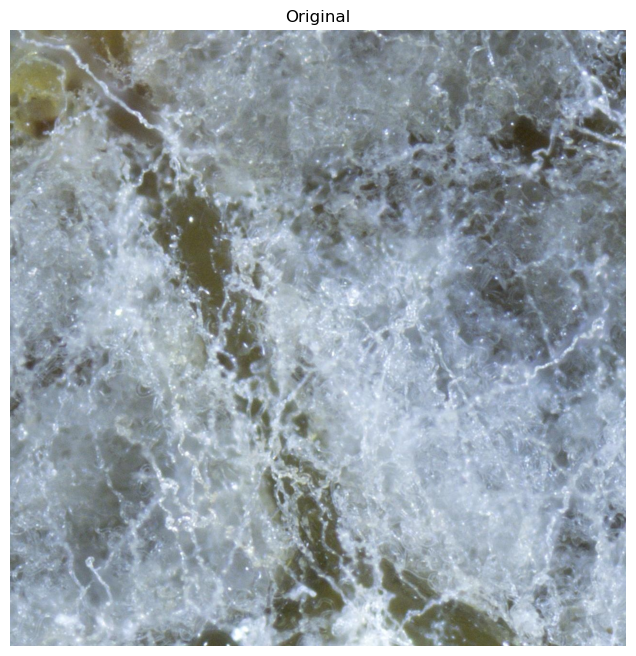

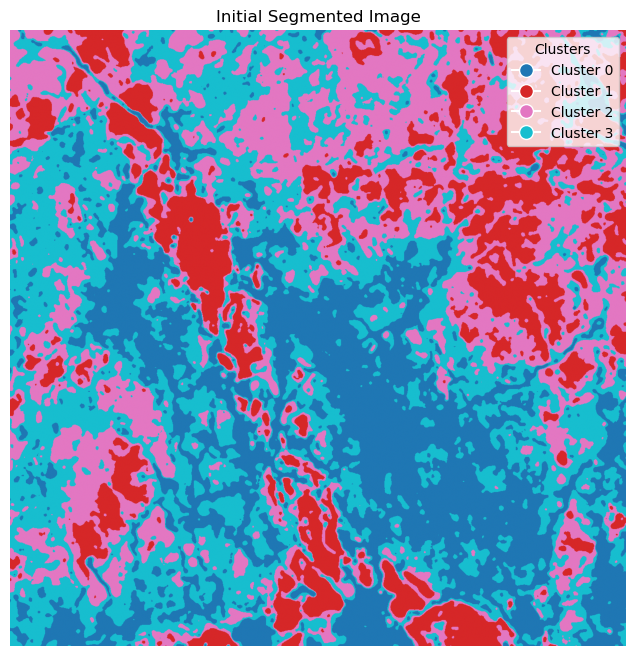

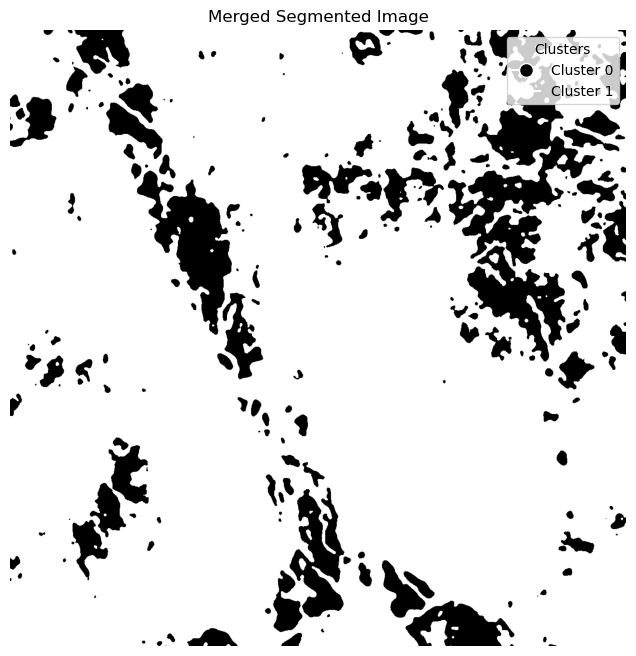

In [105]:
#cmap = plt.get_cmap("viridis", num_clusters)  # Use a discrete colormap
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.title("Original")

# Show original segmentation with legend
show_cluster_legend(segmented_image, "Initial Segmented Image", "Clusters")

final_classes = merge_clusters(best_image[4])
merged_mask, classes = relabel_image_by_class(segmented_image, final_classes)
show_cluster_legend(merged_mask, "Merged Segmented Image", "Clusters")